**Fractal compression**

Fractal compression is a lossy compression method for digital images, based on fractals. The method is best suited for textures and natural images, relying on the fact that parts of an image often resemble other parts of the same image.Fractal algorithms convert these parts into mathematical data called "fractal codes" which are used to recreate the encoded image.Once an image has been converted into fractal code its
relationship to a specific resolution has been lost; it
becomes resolution independent.The image can be
recreated to fill any screen size without the loss of
sharpness that occurs in other compression schemes.
Fractal-based techniques produce outstanding results in
terms of compression in images, retaining a high degree of
self-similarity. Another interesting feature of fractal-based
techniques is their ability to produce a good-quality
rendered image for an arbitrary scaling factor

To do fractal compression , the image is divided into sub-blocks. Then for each block , the most similiar block if found in a half size version of the image and stored. This is done for each block.
Then during decompression, the opposite is done iteratively to recover the original image.

It is not a compression technique for compressing fractals ( e.g. a Mandlebrot set ) as it is commonly misunderstood but is a compression technique which can be used for any digital image.

Fractal Image Decoding is resolution independent. That is , if you compress a 64x64 image , you can decompress it to any size ( say 128x128) without as much loss in quality as you would have for normal zoom.









0/32 ; 0/32


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


0/32 ; 1/32
0/32 ; 2/32
0/32 ; 3/32
0/32 ; 4/32
0/32 ; 5/32
0/32 ; 6/32
0/32 ; 7/32
0/32 ; 8/32
0/32 ; 9/32
0/32 ; 10/32
0/32 ; 11/32
0/32 ; 12/32
0/32 ; 13/32
0/32 ; 14/32
0/32 ; 15/32
0/32 ; 16/32
0/32 ; 17/32
0/32 ; 18/32
0/32 ; 19/32
0/32 ; 20/32
0/32 ; 21/32
0/32 ; 22/32
0/32 ; 23/32
0/32 ; 24/32
0/32 ; 25/32
0/32 ; 26/32
0/32 ; 27/32
0/32 ; 28/32
0/32 ; 29/32
0/32 ; 30/32
0/32 ; 31/32
1/32 ; 0/32
1/32 ; 1/32
1/32 ; 2/32
1/32 ; 3/32
1/32 ; 4/32
1/32 ; 5/32
1/32 ; 6/32
1/32 ; 7/32
1/32 ; 8/32
1/32 ; 9/32
1/32 ; 10/32
1/32 ; 11/32
1/32 ; 12/32
1/32 ; 13/32
1/32 ; 14/32
1/32 ; 15/32
1/32 ; 16/32
1/32 ; 17/32
1/32 ; 18/32
1/32 ; 19/32
1/32 ; 20/32
1/32 ; 21/32
1/32 ; 22/32
1/32 ; 23/32
1/32 ; 24/32
1/32 ; 25/32
1/32 ; 26/32
1/32 ; 27/32
1/32 ; 28/32
1/32 ; 29/32
1/32 ; 30/32
1/32 ; 31/32
2/32 ; 0/32
2/32 ; 1/32
2/32 ; 2/32
2/32 ; 3/32
2/32 ; 4/32
2/32 ; 5/32
2/32 ; 6/32
2/32 ; 7/32
2/32 ; 8/32
2/32 ; 9/32
2/32 ; 10/32
2/32 ; 11/32
2/32 ; 12/32
2/32 ; 13/32
2/32 ; 14/32
2/32 ; 15/32
2/

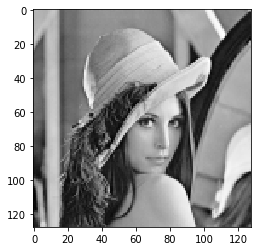

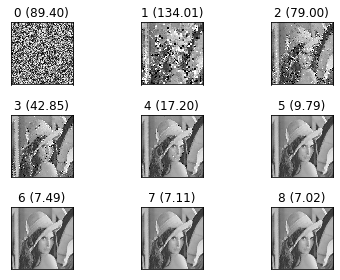

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
from scipy import optimize
import numpy as np
import math
from skimage import io
import numpy 
import math
import cv2




def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))




# Manipulate channels

def get_greyscale_image(img):
    return np.mean(img[:,:,:2], 2)

def extract_rgb(img):
    return img[:,:,0], img[:,:,1], img[:,:,2]

def assemble_rbg(img_r, img_g, img_b):
    shape = (img_r.shape[0], img_r.shape[1], 1)
    return np.concatenate((np.reshape(img_r, shape), np.reshape(img_g, shape), 
        np.reshape(img_b, shape)), axis=2)

# Transformations

def reduce(img, factor):
    result = np.zeros((img.shape[0] // factor, img.shape[1] // factor))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i,j] = np.mean(img[i*factor:(i+1)*factor,j*factor:(j+1)*factor])
    return result

def rotate(img, angle):
    return ndimage.rotate(img, angle, reshape=False)

def flip(img, direction):
    return img[::direction,:]

def apply_transformation(img, direction, angle, contrast=1.0, brightness=0.0):
    return contrast*rotate(flip(img, direction), angle) + brightness

# Contrast and brightness

def find_contrast_and_brightness1(D, S):
    # Fix the contrast and only fit the brightness
    contrast = 0.75
    brightness = (np.sum(D - contrast*S)) / D.size
    return contrast, brightness 

def find_contrast_and_brightness2(D, S):
    # Fit the contrast and the brightness
    A = np.concatenate((np.ones((S.size, 1)), np.reshape(S, (S.size, 1))), axis=1)
    b = np.reshape(D, (D.size,))
    x, _, _, _ = np.linalg.lstsq(A, b)
    #x = optimize.lsq_linear(A, b, [(-np.inf, -2.0), (np.inf, 2.0)]).x
    return x[1], x[0]

# Compression for greyscale images

def generate_all_transformed_blocks(img, source_size, destination_size, step):
    factor = source_size // destination_size
    transformed_blocks = []
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            # Extract the source block and reduce it to the shape of a destination block
            S = reduce(img[k*step:k*step+source_size,l*step:l*step+source_size], factor)
            # Generate all possible transformed blocks
            for direction, angle in candidates:
                transformed_blocks.append((k, l, direction, angle, apply_transformation(S, direction, angle)))
    return transformed_blocks

def compress(img, source_size, destination_size, step):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks(img, source_size, destination_size, step)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    for i in range(i_count):
        transformations.append([])
        for j in range(j_count):
            print("{}/{} ; {}/{}".format(i, i_count, j, j_count))
            transformations[i].append(None)
            min_d = float('inf')
            # Extract the destination block
            D = img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size]
            # Test all possible transformations and take the best one
            for k, l, direction, angle, S in transformed_blocks:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S = contrast*S + brightness
                d = np.sum(np.square(D - S))
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direction, angle, contrast, brightness)
    return transformations

def decompress(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.random.randint(0, 256, (height, width))]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
        print(i_iter)
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                # Apply transform
                k, l, flip, angle, contrast, brightness = transformations[i][j]
                S = reduce(iterations[-1][k*step:k*step+source_size,l*step:l*step+source_size], factor)
                D = apply_transformation(S, flip, angle, contrast, brightness)
                cur_img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    return iterations

# Compression for color images

def reduce_rgb(img, factor):
    img_r, img_g, img_b = extract_rgb(img)
    img_r = reduce(img_r, factor)
    img_g = reduce(img_g, factor)
    img_b = reduce(img_b, factor)
    return assemble_rbg(img_r, img_g, img_b)

def compress_rgb(img, source_size, destination_size, step):
    img_r, img_g, img_b = extract_rgb(img)
    return [compress(img_r, source_size, destination_size, step), \
        compress(img_g, source_size, destination_size, step), \
        compress(img_b, source_size, destination_size, step)]

def decompress_rgb(transformations, source_size, destination_size, step, nb_iter=8):
    img_r = decompress(transformations[0], source_size, destination_size, step, nb_iter)[-1]
    img_g = decompress(transformations[1], source_size, destination_size, step, nb_iter)[-1]
    img_b = decompress(transformations[2], source_size, destination_size, step, nb_iter)[-1]
    return assemble_rbg(img_r, img_g, img_b)

# Plot

def plot_iterations(iterations, target=None):
    # Configure plot
    plt.figure()
    nb_row = math.ceil(np.sqrt(len(iterations)))
    nb_cols = nb_row
    # Plot
    print(len(iterations))
    for i, img in enumerate(iterations):
        plt.subplot(nb_row, nb_cols, i+1)
        if i==(len(iterations)-1):
          print(" PSNR value is :  "+str(psnr(target,img)))
        
        plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
        if target is None:
            plt.title(str(i))
        else:
            # Display the RMSE
            plt.title(str(i) + ' (' + '{0:.2f}'.format(np.sqrt(np.mean(np.square(target - img)))) + ')')
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
    plt.tight_layout()

# Parameters

directions = [1, -1]
angles = [0, 90, 180, 270]
candidates = [[direction, angle] for direction in directions for angle in angles]

# Tests

def test_greyscale():
    img = io.imread("http://optipng.sourceforge.net/pngtech/img/lena.png")
    #img = mpimg.imread(f)
    img = get_greyscale_image(img)
    img = reduce(img, 4)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation='none')
    transformations = compress(img, 8, 4, 8)
    
    iterations = decompress(transformations, 8, 4, 8)
    plot_iterations(iterations, img)
    plt.show()

def test_rgb():
  
    #img = mpimg.imread('lena.gif')
    img = io.imread("https://users.cs.northwestern.edu/~agupta/_projects/image_processing/web/FractalImageCompression/v1/monkey.gif")
    img = reduce_rgb(img, 8)
    transformations = compress_rgb(img, 8, 4, 8)
    retrieved_img = decompress_rgb(transformations, 8, 4, 8)
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.array(img).astype(np.uint8), interpolation='none')
    plt.subplot(122)
    plt.imshow(retrieved_img.astype(np.uint8), interpolation='none')
    plt.show()
                    
if __name__ == '__main__':
    
    test_greyscale()
    #test_rgb()

**Benefits of fractal compression**

Fractal image compression is a lossy
compression method for digital images, based on fractals. The
method is best suited for textures and natural images, relying
on the fact that parts of an image often resemble other parts
of the same image. Fractal Encoding involves partitioning the
images into Range Blocks and Domain. Blocks and each
Range Block is mapped onto the Domain Blocks by using
contractive transforms called the Affine Transforms. The
Fractal encoding technique takes a longer encoding time and
less decoding time.We are going to analyze soft computing
techniques for fractal image compression.

Advantages and disadvantages of fractal image
compression:

When the fractal image compression is compared to other
methods used to compress different images, some of the
main advantages and disadvantages can be summarized.

Advantages:

 Good mathematical encoding frame.

 Resolution-free decoding.

 High compression ratio

 Quick decompression.

Disadvantages:

 Slow encoding.

**Conclusion**

In this study the basics of fractal coding are discussed. In
addition the advantages and disadvantages in the fractal
coding are summarized through the discussion of the
exiting work. The field of fractal compression is relatively
new, as is the study of fractals, and as such there is no
standardized approach to this technique. The fractal method
has the benefit of faster decompression speed, having done
most of the computation during the compression step,
while giving equal or better compression ratio. These
advantages mean that fractal image compression is well
suited for applications requiring fast access to high-quality
images. Fractal Image Compression is a much promising
and still young technology that can fit well in many areas
of the multimedia systems' world.